# Configuration 1

In [90]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym

# import os
# os.environ["SDL_VIDEODRIVER"] = "dummy"
# from IPython.display import clear_output

import matplotlib.pyplot as plt


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, k=batch_size) #pas de remis (test) ? sinon rd.choices

    def __len__(self):
        return len(self.memory)


class Net(nn.Module):
    def __init__(self, obs_shape, hidden_size, n_actions):
        super(Net, self).__init__()
        input_size = int(np.prod(obs_shape))  # This ensures proper flattening
        
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        x = x.float()
        batch_size = x.size(0)
        # Aplatir explicitement de [batch_size, 7, 8, 8] à [batch_size, 448]
        x = x.reshape(batch_size, -1)
        return self.net(x)



class DQN:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        batch_size,
        buffer_capacity,
        update_target_every,
        epsilon_start,
        decrease_epsilon_factor,
        epsilon_min,
        learning_rate,
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = (
            decrease_epsilon_factor  # larger -> more exploration
        )
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """

        # add data to replay buffer
        self.buffer.push(
            torch.tensor(state, dtype=torch.float32).unsqueeze(0),
            torch.tensor([action], dtype=torch.int64),  # plus de double [[]]
            torch.tensor([reward], dtype=torch.float32),
            torch.tensor([terminated], dtype=torch.int64),
            torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        )


        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        (
            state_batch,
            action_batch,
            reward_batch,
            terminated_batch,
            next_state_batch,
        ) = tuple([torch.cat(data) for data in zip(*transitions)])

        values = self.q_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)

        
        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(
                next_state_batch
            ).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()

        if not ((self.n_steps + 1) % self.update_target_every):
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.decrease_epsilon()

        self.n_steps += 1
        if terminated:
            self.n_eps += 1

        return loss.item()
    
    
    def get_q(self, state):
        """
        Compute Q function for a states
        """
        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor) # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)
    

    def get_action(self, env, state, epsilon=None):
        """
        Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.get_q(state))

    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
            np.exp(-1.0 * self.n_eps / self.decrease_epsilon_factor)
        )

    def reset(self):
        hidden_size = 128

        #obs_size = self.observation_space.shape[0] #1D
        obs_shape = self.observation_space.shape
        n_actions = self.action_space.n

        self.q_net = Net(obs_shape, hidden_size, n_actions)
        self.target_net = Net(obs_shape, hidden_size, n_actions)


        self.buffer = ReplayBuffer(self.buffer_capacity)

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.q_net.parameters(), lr=self.learning_rate
        )

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0


In [91]:
import gymnasium as gym
import highway_env
import numpy as np
import torch
#from dqn1 import DQN
from configuration1 import config_dict
from IPython.display import Video, display
import os
import matplotlib.pyplot as plt

# Création de l'environnement
env = gym.make('highway-v0', render_mode="rgb_array")
env.unwrapped.configure(config_dict)
env.reset()

# Paramètres du DQN
agent = DQN(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    batch_size=64,
    buffer_capacity=100000,
    update_target_every=100,
    epsilon_start=1.0,
    decrease_epsilon_factor=500,
    epsilon_min=0.05,
    learning_rate=1e-3,
)

n_episodes = 500
rewards_per_episode = []


# boucle entrainement
for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(env, state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated        
        loss = agent.update(state, action, reward, done, next_state)
        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)
    print(f"Episode {episode}, Reward = {total_reward}, Epsilon = {agent.epsilon:.3f}")

env.close()

Episode 0, Reward = 9.499554305808765, Epsilon = 1.000
Episode 1, Reward = 10.031104065671427, Epsilon = 1.000
Episode 2, Reward = 3.2771347736625516, Epsilon = 1.000
Episode 3, Reward = 4.572648964000924, Epsilon = 1.000
Episode 4, Reward = 31.968404137861796, Epsilon = 1.000
Episode 5, Reward = 5.285064080945681, Epsilon = 0.998
Episode 6, Reward = 16.092630227981616, Epsilon = 0.996
Episode 7, Reward = 2.5785678716462126, Epsilon = 0.994
Episode 8, Reward = 6.182852248623301, Epsilon = 0.992
Episode 9, Reward = 1.208187564194728, Epsilon = 0.991
Episode 10, Reward = 13.881040779115935, Epsilon = 0.989
Episode 11, Reward = 1.4438014403292183, Epsilon = 0.987
Episode 12, Reward = 4.937161123749192, Epsilon = 0.985
Episode 13, Reward = 9.06815844772213, Epsilon = 0.983
Episode 14, Reward = 4.234591256304165, Epsilon = 0.981
Episode 15, Reward = 7.968398530685656, Epsilon = 0.979
Episode 16, Reward = 5.031167852057877, Epsilon = 0.977
Episode 17, Reward = 2.48928144075111, Epsilon = 0.9

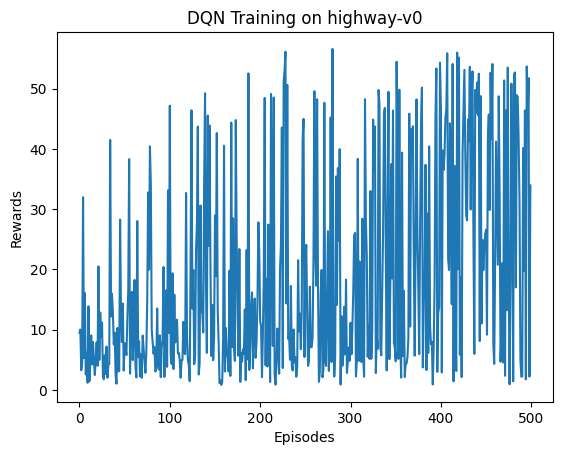

In [92]:
#plot
plt.plot(rewards_per_episode)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("DQN Training on highway-v0")
plt.show()

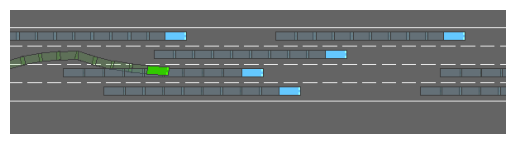

Reward total de l'épisode : 55.59819849789406


In [98]:
import gymnasium as gym
import highway_env
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

# Créer l'env
env = gym.make('highway-v0', render_mode='rgb_array')
env.unwrapped.configure(config_dict)
env.metadata['render_fps'] = 30 # FPS pour le rendu

# Ici c'est ton agent DQN déjà entraîné
# Exemple : agent.load("dqn_highway.pth") si tu l'as sauvegardé

def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)  # On clone pour ne pas toucher au vrai env
    done = False
    state, _ = display_env.reset()
    rewards = 0

    while not done:
        action = agent.get_action(env, state)
        state, reward, terminated, truncated, _ = display_env.step(action)
        done = terminated or truncated
        rewards += reward
        
        if display:
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.axis('off')
            plt.show()
    
    if display:
        display_env.close()

    print(f"Reward total de l'épisode : {rewards}")

# Lancer une visualisation de ton agent DQN :
run_one_episode(env, agent, display=True)
